In [1]:
import util
import numpy as np

# Gaussian Process Regression

Gaussian Processes are a non-parametric method of supervised learning that outputs the prediction on a new input after certain observations $(X, y)$. Unlike other generative approaches that learn the distribution of underlying data and weights, GPs aim to learn directly the distribution over functions $f: X \in R^d \rightarrow y \in R^n$ directly over the function space.

In a Gaussian Process, given an input point $x \in R^d$, we sample a function $f \text{~}GP(m(x), k(x, x'))$ which is a Gaussian distribution, and output the value of $f$ evaluated on $x, f(x)$. Then, given $n$ observations $x_1,.., x_n$, we have that for any $f$ sampled from the prior distribution $f | X$, the output is given as:

$$
\begin{equation*}
f = \{f(x_1),...,f(x_n) \}
\end{equation*}
$$

and the mean and covariance given by:

$$
\begin{equation*}
\mu = \{E[f(x_1)],...,E[f(x_n)]\} = \{m(x_1),...,,m(x_n)\}
\end{equation*}
$$

$$
\begin{equation*}
K = [K_{ij} = \kappa(x_i, x_j)]_{n \times n}
\end{equation*}
$$

Where the kernel function $\kappa$ explicitly defines the covariance matrix $K$ of the distribution. In this example, we use a common kernel function known as the Gaussian or Radial Basis Function(RBF), defined as:

$$
\begin{equation*}
\kappa(x, x') = \text{exp}^{-\frac{|x - x'|^2}{2l^2}}
\end{equation*}
$$

where $l$ is the length scale parameter. Intuitively, the RBF kernel measures the notion of similarity between 2 data points $x, x'$. For simplicity, we shall set $l=1$.

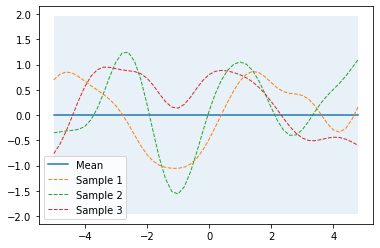

In [2]:
from gaussian_processes import gp_regression, gp_regression_fast
from gp_plot import plot_gp
from kernels import rbf

# Random input points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Mean and covariance of the prior distribution over functions
mu = np.zeros(X.shape)
cov = rbf(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, confidence interval and samples 
plot_gp(mu, cov, X, samples=samples)

Often we define a prior on the probability distribution of functions $f|X$ with mean $m(x) = 0$ and covariance matrix $K$ on observations $(X, y)$. In this case, we wish to ask the question: What is the most likely value of new inputs $X^*$ given the observations we make? More formally, let $f^*$ be the function that is sampled from the posterior probability distribution $f*|X,y,X^*$. Then, by property of Gaussian Processes, we have the following joint distribution:

$$
\begin{equation*}
\begin{bmatrix}
f \\
f^*
\end{bmatrix}
\end{equation*} \text{~}GP
\left(0, 
\begin{bmatrix}
\kappa(X, X) & \kappa(X, X^*)\\
\kappa(X^*, X) & \kappa(X^*, X^*)
\end{bmatrix}
\right)
$$

This allows us to derive the posterior probability of $f^*$ with the following mean and covariance matrix(Full details can be found in section 2.2 of GPML textbook):

$$
\begin{equation*}
\bar{f^*} = E[f^*|X,y,X^*] = {\kappa(X, X^*)}^T[\kappa(X, X) + \sigma^2_nI]^{-1}y
\end{equation*}
$$

$$
\begin{equation*}
\text{cov}(f^*) = \kappa(X^*, X^*) - \kappa(X^*, X)[K(X, X) + \sigma^2_nI]^{-1}\kappa(X^*, X)
\end{equation*}
$$

Where the mean vector $f^*$ represents the expected predictions of $f^*$ on new inputs $X^*$. For the full algorithm used, see Algorithm 2.1 in GPML.

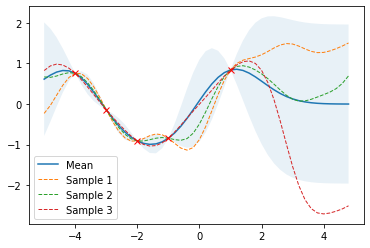

In [3]:
# Generate noiseless training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
y_train = np.sin(X_train)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = gp_regression(X_train, y_train, X)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=y_train, samples=samples)

## Cholesky Decomposition

When the covariance matrix $K$ gets large, it becomes computationally expensive to compute direct inverses on the matrix itself to obtain $(K + \sigma^2_n I)^{-1}$. We now leverage on the fact that $(K + \sigma^2_n I)$ is \textit{positive semi-definite} by property of a valid kernel function to compute the inverse in a faster manner using \textbf{Cholesky Decomposition}. Using Cholesky Decomposition, the matrix $(K + \sigma^2_n I)$ can be decomposed into $LL^T$, where $L$ is a lower triangular matrix. Then, the inversion step can be reproduced in the following manner:

$$
\begin{equation*}
\begin{aligned}
&(K + \sigma^2_n I)(K + \sigma^2_n I)^{-1}y = y\\
&(LL^T)(K + \sigma^2_n I)^{-1}y = y\\
&(LL^T)(K + \sigma^2_n I)^{-1}y = LXy \text{ for some matrix $X$}\\
&(L^T)(K + \sigma^2_n I)^{-1}y = Xy
\end{aligned}
\end{equation*}
$$

where $L(Xy) = y \implies Xy = L \text{\ } y$. This gives us that $(K + \sigma^2_n I)^{-1}y$ is the result of solving the last line in the above equation, which is $L^T \text{\ } (L \text{\ } y)$.

**Note**: the \ symbol represents left matrix divide: $A$ \ $b$ is the vector $x$ that is the solution to $Ax = b$.

/media/wychoong/New Volume/GPML/gp_plot.py:10: RuntimeWarning: invalid value encountered in sqrt
  uncertainty = 1.96 * np.sqrt(np.diag(cov))


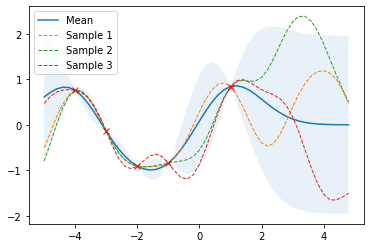

In [4]:
# Version using Cholesky Decomposition - Only improves speed of computation of inverse
mu_ss, cov_ss, log_likelihood_ss = gp_regression_fast(X_train, y_train, X)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_ss, cov_ss, X, X_train=X_train, Y_train=y_train, samples=samples)

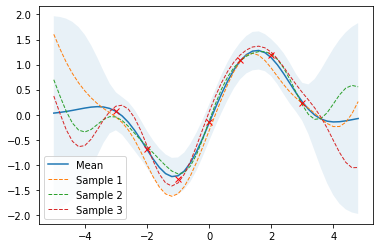

In [5]:
# GP Regression for noisy data
noise = 0.2

# Noisy training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s, log_likelihood_s = gp_regression_fast(X_train, Y_train, X, sigma_y=noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

We can vary the hyperparameters of the Gaussian Process to achieve different results:
<ul> 
    <li> $l$: The length scale parameter affects how fast the functions $f$ changes with changes in the inputs $x$. High values of $l$ means results in high variance even with small distances between points, while low $l$ preseves smoothness at the cost of coarser approximation.
    <li> The signal variance $d$ controls the overall verticality of regions between input points. Higher values of $d$ means greater ranges between the inputs
    <li> The noise parameter $\sigma_y$ represents the amount of noise in the training data as we have seen previously. Higher noise means coarser approximations, but also less overfitting to noisy data
</ul>

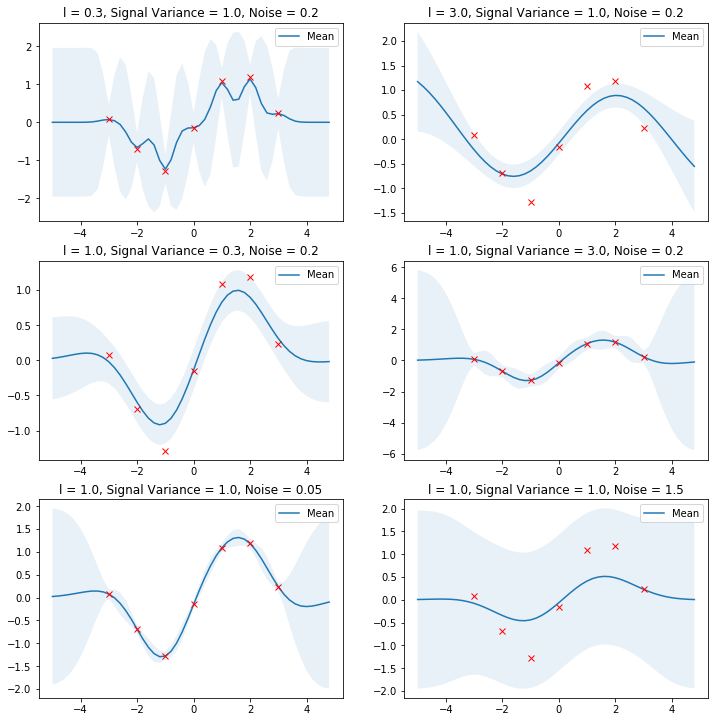

In [6]:
# Effects of varying hyperparameters
import matplotlib.pyplot as plt

params = [
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
]

plt.figure(figsize=(12, 5))

# Vary length scale, signal variance and noise
for i, (l, d, sigma_y) in enumerate(params):
    mu_s, cov_s, log_likelihood_s = gp_regression_fast(X_train, Y_train, X, l=l, d=d, sigma_y=sigma_y)
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, Signal Variance = {d}, Noise = {sigma_y}')
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)